In [1]:
# Data processing
import numpy as np
import pandas as pd
import xarray as xr
import iris
import iris.pandas
from iris.experimental import stratify
from iris.analysis import trajectory
import warnings
warnings.filterwarnings('ignore', module='iris')
from pathlib import Path
import dateutil.parser
from datetime import datetime, timedelta
# Visualization
import cartopy.util
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
# Scientific parameters
M_air = 28.97 # molar mass of dry air [kg]
# Coefficients to convert mass mixing ratio to volume mixing ratio
coeff_c2h6 = (M_air/30.0690)*1e12 # Ethane_WAS
coeff_c3h8 = (M_air/44.0956)*1e12 # Propane_WAS
coeff_nc4h10 = (M_air/58.1222)*1e12 # n-Butane_WAS
coeff_ic4h10 = (M_air/58.1222)*1e12 # i-Butane_WAS
coeff_nc5h12 = (M_air/72.1488)*1e12 # n-Pentane_WAS
coeff_ic5h12 = (M_air/72.1488)*1e12 # i-Pentane_WAS
coeff_meono2 = (M_air/77.0394)*1e12 # MeONO2_WAS
coeff_sbuono2 = (M_air/119.1192)*1e12 # 2-BuONO2_WAS or sBuONO2
coeff_n2peono2 = (M_air/133.1457)*1e12 # 2-PenONO2_WAS or n2PeONO2 or nPeBONO2
coeff_n3peono2 = (M_air/133.1457)*1e12 # 3-PenONO2_WAS or n3PeONO2 or nPeCONO2
coeff_ipeono2 = (M_air/133.1457)*1e12 # 3-Methyl-2-BuONO2_WAS or iPeONO2 or iPeBONO2
# Plotting parameters
plt.rcParams['mathtext.default'] = 'regular'
savefig = False
# Species names
str_c2h6 = '$C_2H_6$'; str_c3h8 = '$C_3H_8$'
str_nc4h10 = '$nC_4H_{10}$'; str_ic4h10 = '$iC_4H_{10}$'
str_nc5h12 = '$nC_5H_{12}$'; str_ic5h12 = '$iC_5H_{12}$'
str_meono2 = '$MeONO_2$'; str_sbuono2 = '2-$BuONO_2$'
str_n2peono2 = '2-$PenONO_2$'; str_n3peono2 = '3-$PenONO_2$'; str_ipeono2 = '3-Methyl-2-$BuONO_2$'

#### Read data

In [2]:
# Read ATom NetCDF files
path_obs_atom = Path('../../external_data/ATom/nc/data')
# One flight at a time
fname_atom_flight = 'MER-WAS_DC8_20160729_R14.nc'
atom_dsinf = xr.open_dataset(path_obs_atom / fname_atom_flight, decode_times=True)
atom_dsmms = xr.open_dataset(path_obs_atom / fname_atom_flight, group='MMS', decode_cf=True)
atom_dswas = xr.open_dataset(path_obs_atom / fname_atom_flight, group='WAS', decode_cf=True)

In [3]:
# Read UKCA NetCDF files (takes some time)
ukca_run_name = 'ax631a'
ukca_run_mnth = 'pm201607'
fname_ukca_run = f'{ukca_run_name}.{ukca_run_mnth}.nc'
path_to_ukca_run = Path('../data') / ukca_run_name / 'atom_overlap'
cb_c2h6 = iris.load_cube(str(path_to_ukca_run / fname_ukca_run), 'C2H6 MASS MIXING RATIO AFTER TSTEP')*coeff_c2h6
cb_c3h8 = iris.load_cube(str(path_to_ukca_run / fname_ukca_run), 'C3H8 MASS MIXING RATIO AFTER TSTEP')*coeff_c3h8
cb_nc4h10 = iris.load_cube(str(path_to_ukca_run / fname_ukca_run), 'n-C4H10 MASS MIXING RATIO AFTER TS')*coeff_nc4h10
cb_ic4h10 = iris.load_cube(str(path_to_ukca_run / fname_ukca_run), 'i-C4H10 MASS MIXING RATIO AFTER TS')*coeff_ic4h10
cb_nc5h12 = iris.load_cube(str(path_to_ukca_run / fname_ukca_run), 'n-C5H12 MASS MIXING RATIO AFTER TS')*coeff_nc5h12
cb_ic5h12 = iris.load_cube(str(path_to_ukca_run / fname_ukca_run), 'i-C5H12 MASS MIXING RATIO AFTER TS')*coeff_ic5h12
cb_meono2 = iris.load_cube(str(path_to_ukca_run / fname_ukca_run), 'MeONO2 MASS MIXING RATIO AFTER TSTEP')*coeff_meono2
cb_sbuono2 = iris.load_cube(str(path_to_ukca_run / fname_ukca_run), 's-BuONO2 MASS MIXING RATIO AFTER TS')*coeff_sbuono2
cb_n2peono2 = iris.load_cube(str(path_to_ukca_run / fname_ukca_run), 'n-2PeONO2 MASS MIXING RATIO AFTER TS')*coeff_n2peono2
cb_n3peono2 = iris.load_cube(str(path_to_ukca_run / fname_ukca_run), 'n-3PeONO2 MASS MIXING RATIO AFTER TS')*coeff_n3peono2
cb_ipeono2 = iris.load_cube(str(path_to_ukca_run / fname_ukca_run), 'i-PeONO2 MASS MIXING RATIO AFTER TS')*coeff_ipeono2
# Load altitude coordinate
alt_coord = iris.load_cube(str(Path('../data')/'ukca_coords_n96e_marcus_180705.nc'),'mass_fraction_of_ozone_in_air').coord('altitude')

In [4]:
# Extract datetimes from ATom and UKCA output
# ICARTT docs: 'Time is to be reported as seconds UTC from the start of the date on which measurements began. 
#               This date appears in both the file header and filename.'
t_yr = int(str(atom_dsinf.Flight_ID.values).split('_')[1][0:4])
t_mn = int(str(atom_dsinf.Flight_ID.values).split('_')[1][4:6])
t_da = int(str(atom_dsinf.Flight_ID.values).split('_')[1][6:8])
times = []
for i in atom_dsinf.UTC_Mid_WAS.values:
    times.append(datetime(t_yr,t_mn,t_da,hour=0,minute=0,second=0) + timedelta(seconds=i))
atom_date_start = atom_dsinf.time[0].values.astype('<M8[us]').astype(datetime)
ukca_days_since = dateutil.parser.parse(str(cb_c2h6.coord('t').units)[10::])
ukca_date = ukca_days_since + timedelta(days=cb_c2h6.coord('t').points.tolist()[0])

In [5]:
# Path to results
atom_ukca_datetime_match = f'{atom_date_start.strftime("%y%m%d")}_{ukca_date.strftime("%y%m")}'
path_to_results = Path('../../../results') / ukca_run_name / atom_ukca_datetime_match
path_to_results.mkdir(exist_ok=True) # create a new folder if it doesn't exist
print(atom_ukca_datetime_match)

160729_1607


#### Interpolate model data from hybrid height to absolute height 

In [6]:
# Add altitude coordinate to the cube with model data
cb_c2h6.add_aux_coord(alt_coord, data_dims=[1, 2, 3])
cb_c3h8.add_aux_coord(alt_coord, data_dims=[1, 2, 3])
cb_nc4h10.add_aux_coord(alt_coord, data_dims=[1, 2, 3])
cb_ic4h10.add_aux_coord(alt_coord, data_dims=[1, 2, 3])
cb_nc5h12.add_aux_coord(alt_coord, data_dims=[1, 2, 3])
cb_ic5h12.add_aux_coord(alt_coord, data_dims=[1, 2, 3])
cb_meono2.add_aux_coord(alt_coord, data_dims=[1, 2, 3])
cb_sbuono2.add_aux_coord(alt_coord, data_dims=[1, 2, 3])
cb_n2peono2.add_aux_coord(alt_coord, data_dims=[1, 2, 3])
cb_n3peono2.add_aux_coord(alt_coord, data_dims=[1, 2, 3])
cb_ipeono2.add_aux_coord(alt_coord, data_dims=[1, 2, 3])

In [7]:
# Relevel model data from hybrid_height to target levels using alt_coord
tgt_levels = np.arange(0, 14000, 100) # [meters]
cbr_c2h6 = stratify.relevel(cb_c2h6, alt_coord, tgt_levels, axis='Hybrid height')
cbr_c3h8 = stratify.relevel(cb_c3h8, alt_coord, tgt_levels, axis='Hybrid height')
cbr_nc4h10 = stratify.relevel(cb_nc4h10, alt_coord, tgt_levels, axis='Hybrid height')
cbr_ic4h10 = stratify.relevel(cb_ic4h10, alt_coord, tgt_levels, axis='Hybrid height')
cbr_nc5h12 = stratify.relevel(cb_nc5h12, alt_coord, tgt_levels, axis='Hybrid height')
cbr_ic5h12 = stratify.relevel(cb_ic5h12, alt_coord, tgt_levels, axis='Hybrid height')
cbr_meono2 = stratify.relevel(cb_meono2, alt_coord, tgt_levels, axis='Hybrid height')
cbr_sbuono2 = stratify.relevel(cb_sbuono2, alt_coord, tgt_levels, axis='Hybrid height')
cbr_n2peono2 = stratify.relevel(cb_n2peono2, alt_coord, tgt_levels, axis='Hybrid height')
cbr_n3peono2 = stratify.relevel(cb_n3peono2, alt_coord, tgt_levels, axis='Hybrid height')
cbr_ipeono2 = stratify.relevel(cb_ipeono2, alt_coord, tgt_levels, axis='Hybrid height')

#### Interpolate releved model data to flight track

In [8]:
# Construct 3D flights trajectory
if atom_ukca_datetime_match == '160803_1608':
    # Because ATom flight on 20160803 has one lat, lon, alt value equal to 'nan', have to interpolate between adjacent cells
    # to replace 'nan' with an interpolated value.
    sample_lats = atom_dsmms.G_LAT.interpolate_na(dim='time', method='linear').data
    sample_lons = atom_dsmms.G_LONG.interpolate_na(dim='time', method='linear').data+360
    sample_alts = atom_dsmms.G_ALT.interpolate_na(dim='time', method='linear').data
else:
    sample_lats = atom_dsmms.G_LAT.data 
    sample_lons = atom_dsmms.G_LONG.data+360
    sample_alts = atom_dsmms.G_ALT.data
sample_lats_lons_alts = [('latitude', sample_lats), ('longitude', sample_lons), ('altitude', sample_alts)]

In [9]:
# Interpolate model data to flights trajectory (takes some time)
traj3d_cbr_c2h6 = trajectory.interpolate(cbr_c2h6, sample_lats_lons_alts)
traj3d_cbr_c3h8 = trajectory.interpolate(cbr_c3h8, sample_lats_lons_alts)
traj3d_cbr_nc4h10 = trajectory.interpolate(cbr_nc4h10, sample_lats_lons_alts)
traj3d_cbr_ic4h10 = trajectory.interpolate(cbr_ic4h10, sample_lats_lons_alts)
traj3d_cbr_nc5h12 = trajectory.interpolate(cbr_nc5h12, sample_lats_lons_alts)
traj3d_cbr_ic5h12 = trajectory.interpolate(cbr_ic5h12, sample_lats_lons_alts)
traj3d_cbr_meono2 = trajectory.interpolate(cbr_meono2, sample_lats_lons_alts)
traj3d_cbr_sbuono2 = trajectory.interpolate(cbr_sbuono2, sample_lats_lons_alts)
traj3d_cbr_n2peono2 = trajectory.interpolate(cbr_n2peono2, sample_lats_lons_alts)
traj3d_cbr_n3peono2 = trajectory.interpolate(cbr_n3peono2, sample_lats_lons_alts)
traj3d_cbr_ipeono2 = trajectory.interpolate(cbr_ipeono2, sample_lats_lons_alts)

#### Time series of concentrations along flight track

In [10]:
# Convert ATom C2H6, C2H4, C2H2, C3H8, C3H6 to pptvC to match UKCA lumped species, namely C2H6=C2H6+C2H4+C2H2, C3H8=C3H8+C3H6
atom_dswas_c2h6 = atom_dswas['Ethane_WAS']*2 + atom_dswas['Ethene_WAS']*2 + atom_dswas['Ethyne_WAS']*2
atom_dswas_c3h8 = atom_dswas['Propane_WAS']*3 + atom_dswas['Propene_WAS']*3

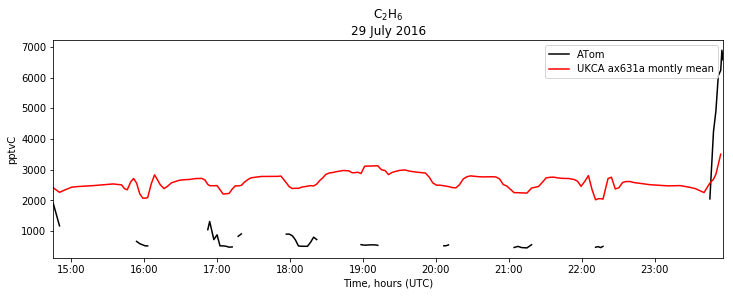

In [11]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(times, atom_dswas_c2h6, color='k')
ax.plot(times, traj3d_cbr_c2h6.data.squeeze()*2, color='r')
# common
ax.set_title(f'{str_c2h6}\n{atom_date_start.strftime("%d %B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptvC')
ax.set_xticklabels(times)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.margins(x=0)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RH_C2.png', bbox_inches='tight')

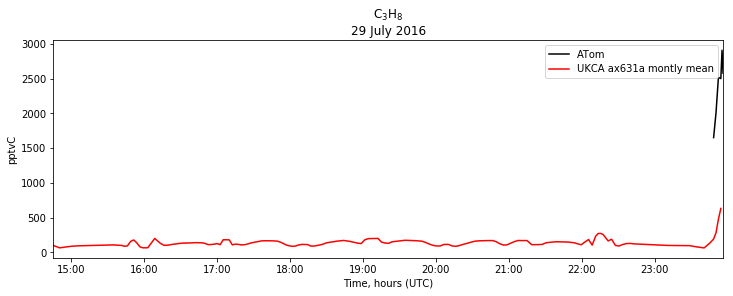

In [12]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(times, atom_dswas_c3h8, color='k')
ax.plot(times, traj3d_cbr_c3h8.data.squeeze()*3, color='r')
# common
ax.set_title(f'{str_c3h8}\n{atom_date_start.strftime("%d %B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptvC')
ax.set_xticklabels(times)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.margins(x=0)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RH_C3.png', bbox_inches='tight')

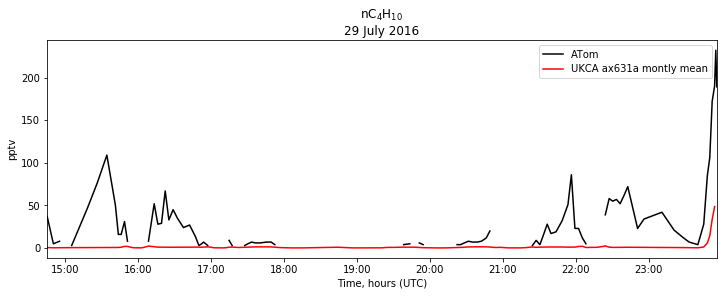

In [13]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(times, atom_dswas['n-Butane_WAS'], color='k')
ax.plot(times, traj3d_cbr_nc4h10.data.squeeze(), color='r')
# common
ax.set_title(f'{str_nc4h10}\n{atom_date_start.strftime("%d %B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv')
ax.set_xticklabels(times)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.margins(x=0)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RH_C4n.png', bbox_inches='tight')

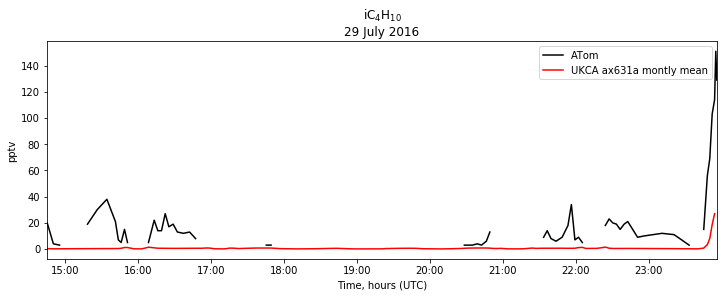

In [14]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(times, atom_dswas['i-Butane_WAS'], color='k')
ax.plot(times, traj3d_cbr_ic4h10.data.squeeze(), color='r')
# common
ax.set_title(f'{str_ic4h10}\n{atom_date_start.strftime("%d %B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv')
ax.set_xticklabels(times)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.margins(x=0)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RH_C4i.png', bbox_inches='tight')

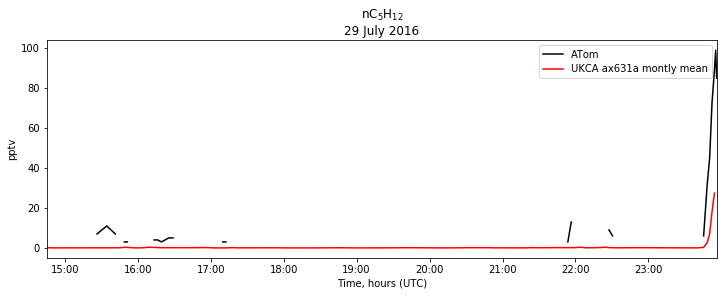

In [15]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(times, atom_dswas['n-Pentane_WAS'], color='k')
ax.plot(times, traj3d_cbr_nc5h12.data.squeeze(), color='r')
# common
ax.set_title(f'{str_nc5h12}\n{atom_date_start.strftime("%d %B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv')
ax.set_xticklabels(times)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.margins(x=0)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RH_C5n.png', bbox_inches='tight')

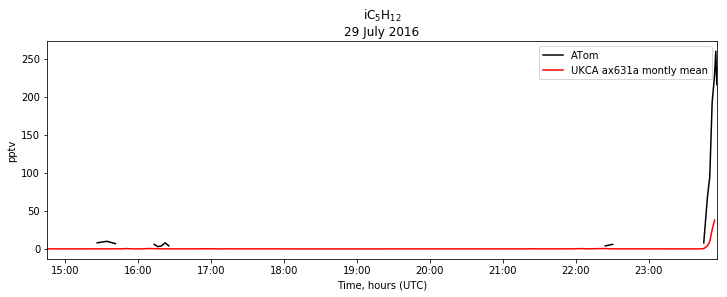

In [16]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(times, atom_dswas['i-Pentane_WAS'], color='k')
ax.plot(times, traj3d_cbr_ic5h12.data.squeeze(), color='r')
# common
ax.set_title(f'{str_ic5h12}\n{atom_date_start.strftime("%d %B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv')
ax.set_xticklabels(times)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.margins(x=0)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RH_C5i.png', bbox_inches='tight')

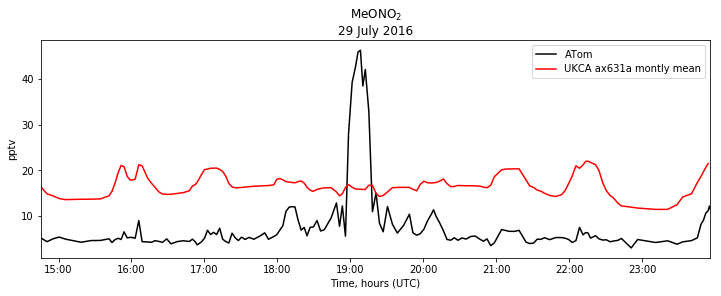

In [17]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(times, atom_dswas['MeONO2_WAS'], color='k')
ax.plot(times, traj3d_cbr_meono2.data.squeeze(), color='r')
# common
ax.set_title(f'{str_meono2}\n{atom_date_start.strftime("%d %B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv')
ax.set_xticklabels(times)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.margins(x=0)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RONO2_C1.png', bbox_inches='tight')

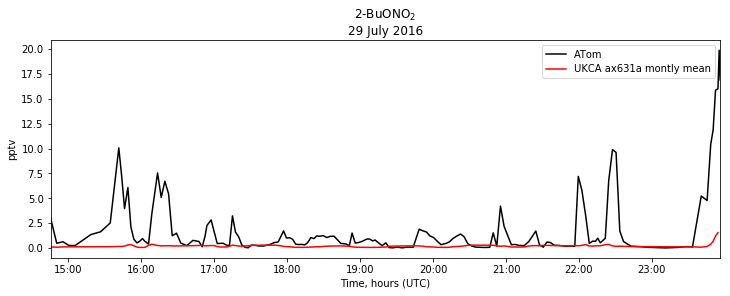

In [18]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(times, atom_dswas['2-BuONO2_WAS'], color='k')
ax.plot(times, traj3d_cbr_sbuono2.data.squeeze(), color='r')
# common
ax.set_title(f'{str_sbuono2}\n{atom_date_start.strftime("%d %B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv')
ax.set_xticklabels(times)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.margins(x=0)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RONO2_C4s.png', bbox_inches='tight')

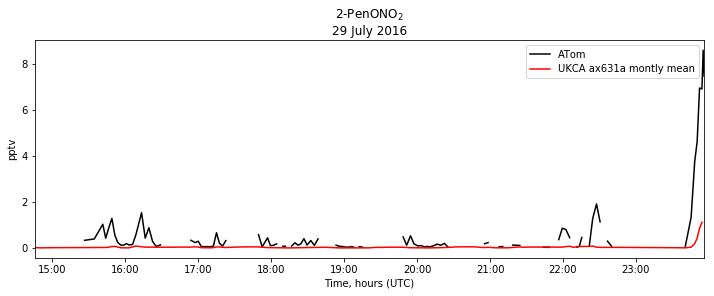

In [19]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(times, atom_dswas['2-PenONO2_WAS'], color='k')
ax.plot(times, traj3d_cbr_n2peono2.data.squeeze(), color='r')
# common
ax.set_title(f'{str_n2peono2}\n{atom_date_start.strftime("%d %B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv')
ax.set_xticklabels(times)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.margins(x=0)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RONO2_C5nB.png', bbox_inches='tight')

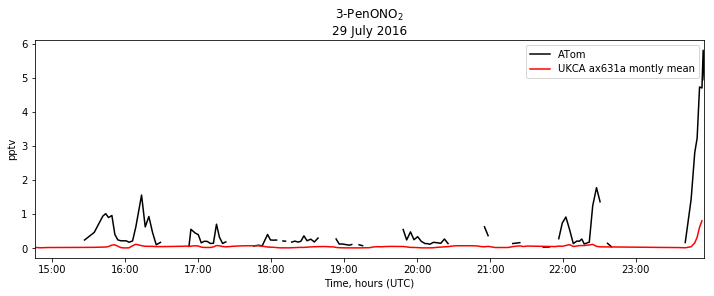

In [20]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(times, atom_dswas['3-PenONO2_WAS'], color='k')
ax.plot(times, traj3d_cbr_n3peono2.data.squeeze(), color='r')
# common
ax.set_title(f'{str_n3peono2}\n{atom_date_start.strftime("%d %B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv')
ax.set_xticklabels(times)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.margins(x=0)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RONO2_C5nC.png', bbox_inches='tight')

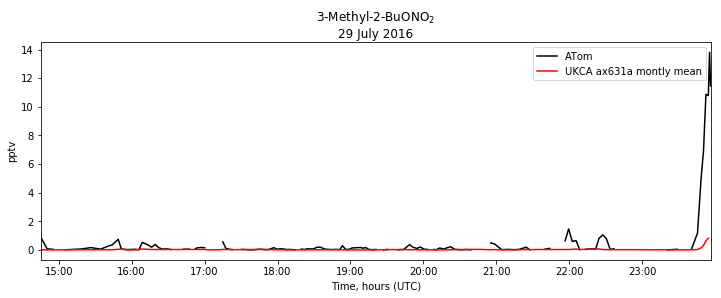

In [21]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(times, atom_dswas['3-Methyl-2-BuONO2_WAS'], color='k')
ax.plot(times, traj3d_cbr_ipeono2.data.squeeze(), color='r')
# common
ax.set_title(f'{str_ipeono2}\n{atom_date_start.strftime("%d %B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv')
ax.set_xticklabels(times)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.margins(x=0)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RONO2_C5i.png', bbox_inches='tight')

#### RONO2/RH time series along flight track

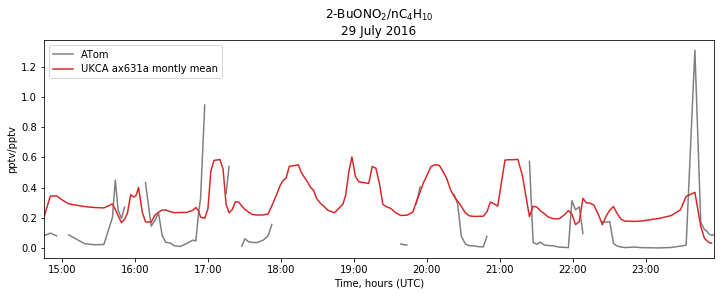

In [22]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(times, atom_dswas['2-BuONO2_WAS']/atom_dswas['n-Butane_WAS'], color='C7')
ax.plot(times, traj3d_cbr_sbuono2.data.squeeze()/traj3d_cbr_nc4h10.data.squeeze(), color='C3')
# common
ax.set_title(f'{str_sbuono2}/{str_nc4h10}\n{atom_date_start.strftime("%d %B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv/pptv')
ax.set_xticklabels(times)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.margins(x=0)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RONO2_RH_C4s.png', bbox_inches='tight')

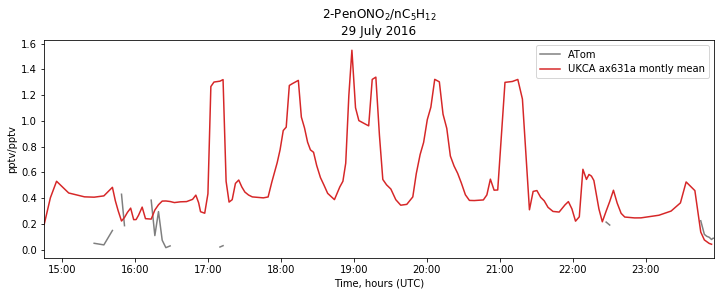

In [23]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(times, atom_dswas['2-PenONO2_WAS']/atom_dswas['n-Pentane_WAS'], color='C7')
ax.plot(times, traj3d_cbr_n2peono2.data.squeeze()/traj3d_cbr_nc5h12.data.squeeze(), color='C3')
# common
ax.set_title(f'{str_n2peono2}/{str_nc5h12}\n{atom_date_start.strftime("%d %B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv/pptv')
ax.set_xticklabels(times)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.margins(x=0)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RONO2_RH_C5nB.png', bbox_inches='tight')

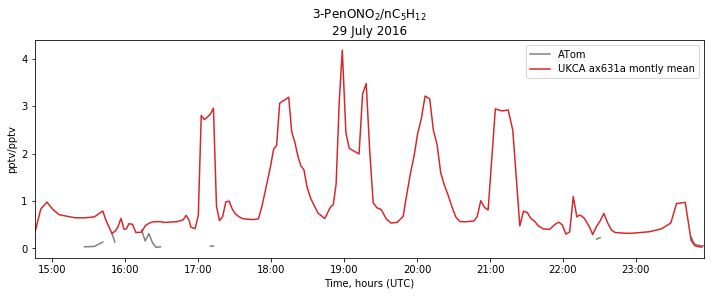

In [24]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(times, atom_dswas['3-PenONO2_WAS']/atom_dswas['n-Pentane_WAS'], color='C7')
ax.plot(times, traj3d_cbr_n3peono2.data.squeeze()/traj3d_cbr_nc5h12.data.squeeze(), color='C3')
# common
ax.set_title(f'{str_n3peono2}/{str_nc5h12}\n{atom_date_start.strftime("%d %B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv/pptv')
ax.set_xticklabels(times)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.margins(x=0)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RONO2_RH_C5nC.png', bbox_inches='tight')

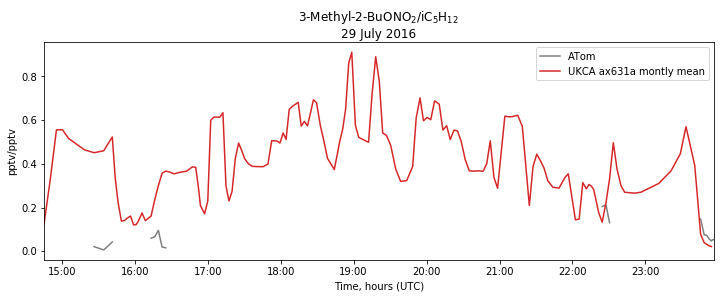

In [25]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(times, atom_dswas['3-Methyl-2-BuONO2_WAS']/atom_dswas['i-Pentane_WAS'], color='C7')
ax.plot(times, traj3d_cbr_ipeono2.data.squeeze()/traj3d_cbr_ic5h12.data.squeeze(), color='C3')
# common
ax.set_title(f'{str_ipeono2}/{str_ic5h12}\n{atom_date_start.strftime("%d %B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv/pptv')
ax.set_xticklabels(times)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.margins(x=0)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RONO2_RH_C5i.png', bbox_inches='tight')

#### Cross section along flight track

In [26]:
# Extract a cross section from model data along flight track (takes some time)
sample_lats_lons = [('latitude', sample_lats), ('longitude', sample_lons)]
traj2d_cbr_c2h6 = trajectory.interpolate(cbr_c2h6, sample_lats_lons)
traj2d_cbr_c3h8 = trajectory.interpolate(cbr_c3h8, sample_lats_lons)
traj2d_cbr_nc4h10 = trajectory.interpolate(cbr_nc4h10, sample_lats_lons)
traj2d_cbr_ic4h10 = trajectory.interpolate(cbr_ic4h10, sample_lats_lons)
traj2d_cbr_nc5h12 = trajectory.interpolate(cbr_nc5h12, sample_lats_lons)
traj2d_cbr_ic5h12 = trajectory.interpolate(cbr_ic5h12, sample_lats_lons)
traj2d_cbr_meono2 = trajectory.interpolate(cbr_meono2, sample_lats_lons)
traj2d_cbr_sbuono2 = trajectory.interpolate(cbr_sbuono2, sample_lats_lons)
traj2d_cbr_n2peono2 = trajectory.interpolate(cbr_n2peono2, sample_lats_lons)
traj2d_cbr_n3peono2 = trajectory.interpolate(cbr_n3peono2, sample_lats_lons)
traj2d_cbr_ipeono2 = trajectory.interpolate(cbr_ipeono2, sample_lats_lons)

In [27]:
# Convert xarray dataset with observational data to pandas dataframe
atom_pdwas_c2h6 = atom_dswas_c2h6.to_dataframe(name='Lumped_C2H6_C2H4_C2H2')
atom_pdwas_c3h8 = atom_dswas_c3h8.to_dataframe(name='Lumped_C3H8_C3H6')
atom_pdwas_nc4h10 = atom_dswas['n-Butane_WAS'].to_dataframe()
atom_pdwas_ic4h10 = atom_dswas['i-Butane_WAS'].to_dataframe()
atom_pdwas_nc5h12 = atom_dswas['n-Pentane_WAS'].to_dataframe()
atom_pdwas_ic5h12 = atom_dswas['i-Pentane_WAS'].to_dataframe()
atom_pdwas_meono2 = atom_dswas['MeONO2_WAS'].to_dataframe()
atom_pdwas_sbuono2 = atom_dswas['2-BuONO2_WAS'].to_dataframe()
atom_pdwas_n2peono2 = atom_dswas['2-PenONO2_WAS'].to_dataframe()
atom_pdwas_n3peono2 = atom_dswas['3-PenONO2_WAS'].to_dataframe()
atom_pdwas_ipeono2 = atom_dswas['3-Methyl-2-BuONO2_WAS'].to_dataframe()

In [28]:
# Find max between maxima and max between minima in ATom and model cross section data for plotting a cross section with two colormaps
cs_c2h6_max = max(np.nanmax(atom_pdwas_c2h6.values), np.nanmax(traj2d_cbr_c2h6.data*2))
cs_c3h8_max = max(np.nanmax(atom_pdwas_c3h8.values), np.nanmax(traj2d_cbr_c3h8.data*3))
cs_nc4h10_max = max(np.nanmax(atom_pdwas_nc4h10.values), np.nanmax(traj2d_cbr_nc4h10.data))
cs_ic4h10_max = max(np.nanmax(atom_pdwas_ic4h10.values), np.nanmax(traj2d_cbr_ic4h10.data))
cs_nc5h12_max = max(np.nanmax(atom_pdwas_nc5h12.values), np.nanmax(traj2d_cbr_nc5h12.data))
cs_ic5h12_max = max(np.nanmax(atom_pdwas_ic5h12.values), np.nanmax(traj2d_cbr_ic5h12.data))
cs_meono2_max = max(np.nanmax(atom_pdwas_meono2.values), np.nanmax(traj2d_cbr_meono2.data))
cs_sbuono2_max = max(np.nanmax(atom_pdwas_sbuono2.values), np.nanmax(traj2d_cbr_sbuono2.data))
cs_n2peono2_max = max(np.nanmax(atom_pdwas_n2peono2.values), np.nanmax(traj2d_cbr_n2peono2.data))
cs_n3peono2_max = max(np.nanmax(atom_pdwas_n3peono2.values), np.nanmax(traj2d_cbr_n3peono2.data))
cs_ipeono2_max = max(np.nanmax(atom_pdwas_ipeono2.values), np.nanmax(traj2d_cbr_ipeono2.data))

cs_c2h6_min = min(np.nanmax(atom_pdwas_c2h6.values), np.nanmax(traj2d_cbr_c2h6.data*2))
cs_c3h8_min = min(np.nanmax(atom_pdwas_c3h8.values), np.nanmax(traj2d_cbr_c3h8.data*3))
cs_nc4h10_min = min(np.nanmax(atom_pdwas_nc4h10.values), np.nanmax(traj2d_cbr_nc4h10.data))
cs_ic4h10_min = min(np.nanmax(atom_pdwas_ic4h10.values), np.nanmax(traj2d_cbr_ic4h10.data))
cs_nc5h12_min = min(np.nanmax(atom_pdwas_nc5h12.values), np.nanmax(traj2d_cbr_nc5h12.data))
cs_ic5h12_min = min(np.nanmax(atom_pdwas_ic5h12.values), np.nanmax(traj2d_cbr_ic5h12.data))
cs_meono2_min = min(np.nanmax(atom_pdwas_meono2.values), np.nanmax(traj2d_cbr_meono2.data))
cs_sbuono2_min = min(np.nanmax(atom_pdwas_sbuono2.values), np.nanmax(traj2d_cbr_sbuono2.data))
cs_n2peono2_min = min(np.nanmax(atom_pdwas_n2peono2.values), np.nanmax(traj2d_cbr_n2peono2.data))
cs_n3peono2_min = min(np.nanmax(atom_pdwas_n3peono2.values), np.nanmax(traj2d_cbr_n3peono2.data))
cs_ipeono2_min = min(np.nanmax(atom_pdwas_ipeono2.values), np.nanmax(traj2d_cbr_ipeono2.data))

In [29]:
# Cross section plotting parameters
def m2km(x, pos):
    '''Convert meters to kilometers when plotting axis labels'''
    return int(x*1e-3) #'{:1.1f}'.format(x*1e-3)
# Merge two colormaps: color concentrations present in obs and model using one colormap and obs higher than model using another colormap
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
colors_low = plt.cm.Blues(np.linspace(0,1,128))
colors_high = plt.cm.autumn_r(np.linspace(0,1,128))
colors_stack = np.vstack((colors_low, colors_high))
mrgd_cmap = colors.LinearSegmentedColormap.from_list('merged_cmap', colors_stack)
cs_pc_kwargs = dict(cmap=mrgd_cmap, vmin=0) # model data pcolormesh options
cs_sc_kwargs = dict(cmap=mrgd_cmap, vmin=0, edgecolors='k', linewidth=0.2) # obs data scatter options

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


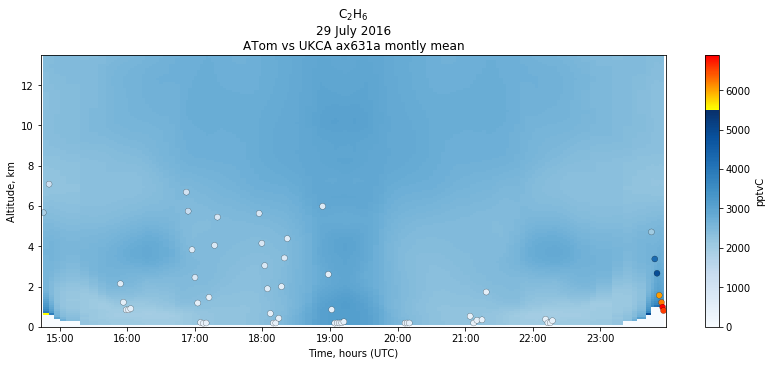

In [30]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(times, traj2d_cbr_c2h6.coord('altitude').points, traj2d_cbr_c2h6.data.squeeze()*2, 
                   norm=MidpointNormalize(midpoint=cs_c2h6_min), vmax=cs_c2h6_max, **cs_pc_kwargs)
p1 = ax.scatter(times, atom_dsmms.G_ALT, c=atom_pdwas_c2h6.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_c2h6_min), vmax=cs_c2h6_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptvC')
# common
ax.set_title(f'{str_c2h6}\n{atom_date_start.strftime("%d %B %Y")}\nATom vs UKCA {ukca_run_name} montly mean')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticklabels(times)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_cs_RH_C2.png', bbox_inches='tight')

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


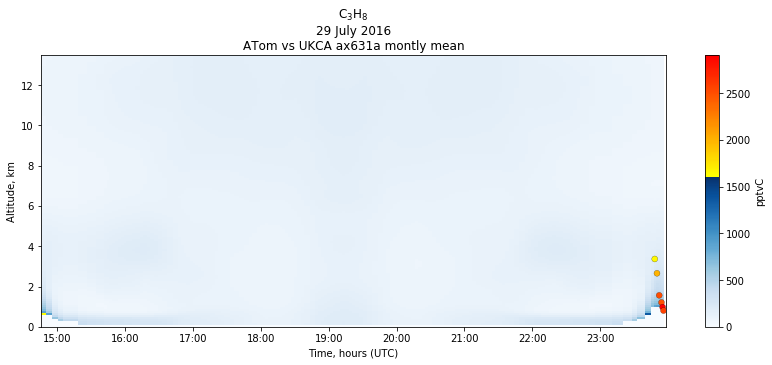

In [31]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(times, traj2d_cbr_c3h8.coord('altitude').points, traj2d_cbr_c3h8.data.squeeze()*3, 
                   norm=MidpointNormalize(midpoint=cs_c3h8_min), vmax=cs_c3h8_max, **cs_pc_kwargs)
p1 = ax.scatter(times, atom_dsmms.G_ALT, c=atom_pdwas_c3h8.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_c3h8_min), vmax=cs_c3h8_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptvC')
# common
ax.set_title(f'{str_c3h8}\n{atom_date_start.strftime("%d %B %Y")}\nATom vs UKCA {ukca_run_name} montly mean')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticklabels(times)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_cs_RH_C3.png', bbox_inches='tight')

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


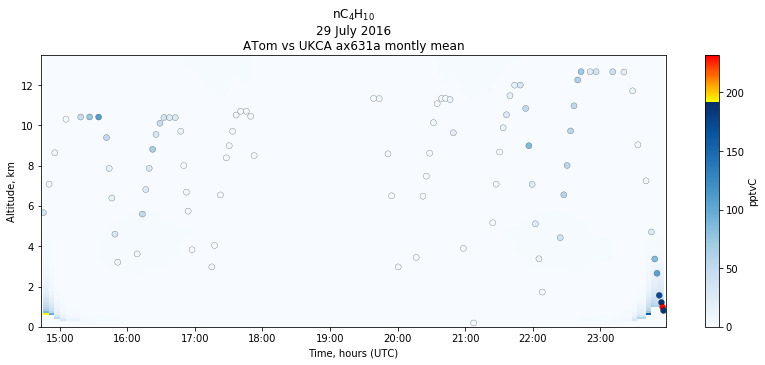

In [32]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(times, traj2d_cbr_nc4h10.coord('altitude').points, traj2d_cbr_nc4h10.data.squeeze(), 
                   norm=MidpointNormalize(midpoint=cs_nc4h10_min), vmax=cs_nc4h10_max, **cs_pc_kwargs)
p1 = ax.scatter(times, atom_dsmms.G_ALT, c=atom_pdwas_nc4h10.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_nc4h10_min), vmax=cs_nc4h10_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptvC')
# common
ax.set_title(f'{str_nc4h10}\n{atom_date_start.strftime("%d %B %Y")}\nATom vs UKCA {ukca_run_name} montly mean')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticklabels(times)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_cs_RH_C4n.png', bbox_inches='tight')

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


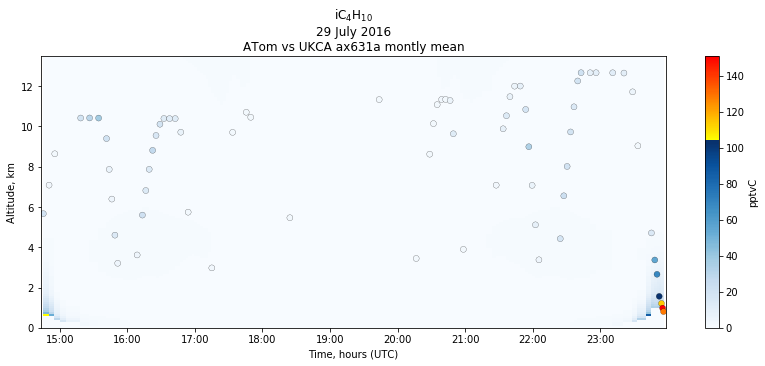

In [33]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(times, traj2d_cbr_ic4h10.coord('altitude').points, traj2d_cbr_ic4h10.data.squeeze(), 
                   norm=MidpointNormalize(midpoint=cs_ic4h10_min), vmax=cs_ic4h10_max, **cs_pc_kwargs)
p1 = ax.scatter(times, atom_dsmms.G_ALT, c=atom_pdwas_ic4h10.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_ic4h10_min), vmax=cs_ic4h10_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptvC')
# common
ax.set_title(f'{str_ic4h10}\n{atom_date_start.strftime("%d %B %Y")}\nATom vs UKCA {ukca_run_name} montly mean')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticklabels(times)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_cs_RH_C4i.png', bbox_inches='tight')

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


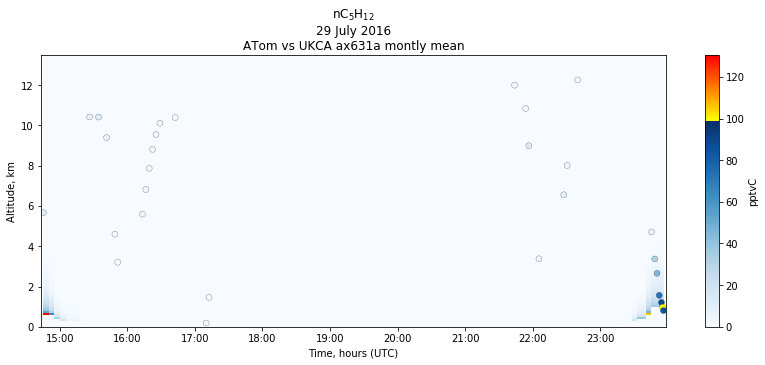

In [34]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(times, traj2d_cbr_nc5h12.coord('altitude').points, traj2d_cbr_nc5h12.data.squeeze(), 
                   norm=MidpointNormalize(midpoint=cs_nc5h12_min), vmax=cs_nc5h12_max, **cs_pc_kwargs)
p1 = ax.scatter(times, atom_dsmms.G_ALT, c=atom_pdwas_nc5h12.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_nc5h12_min), vmax=cs_nc5h12_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptvC')
# common
ax.set_title(f'{str_nc5h12}\n{atom_date_start.strftime("%d %B %Y")}\nATom vs UKCA {ukca_run_name} montly mean')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticklabels(times)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_cs_RH_C5n.png', bbox_inches='tight')

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


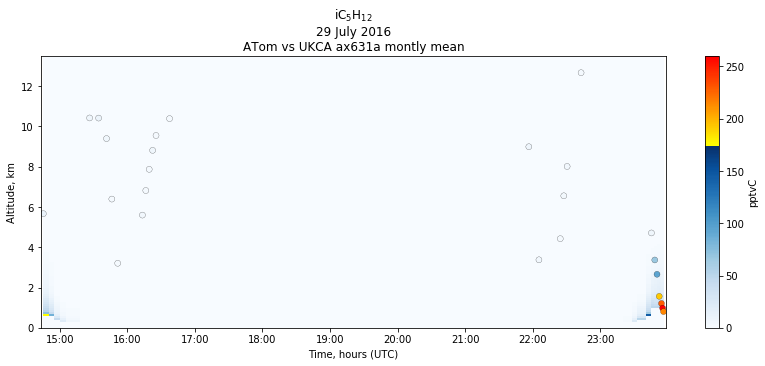

In [35]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(times, traj2d_cbr_ic5h12.coord('altitude').points, traj2d_cbr_ic5h12.data.squeeze(), 
                   norm=MidpointNormalize(midpoint=cs_ic5h12_min), vmax=cs_ic5h12_max, **cs_pc_kwargs)
p1 = ax.scatter(times, atom_dsmms.G_ALT, c=atom_pdwas_ic5h12.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_ic5h12_min), vmax=cs_ic5h12_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptvC')
# common
ax.set_title(f'{str_ic5h12}\n{atom_date_start.strftime("%d %B %Y")}\nATom vs UKCA {ukca_run_name} montly mean')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticklabels(times)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_cs_RH_C5i.png', bbox_inches='tight')

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


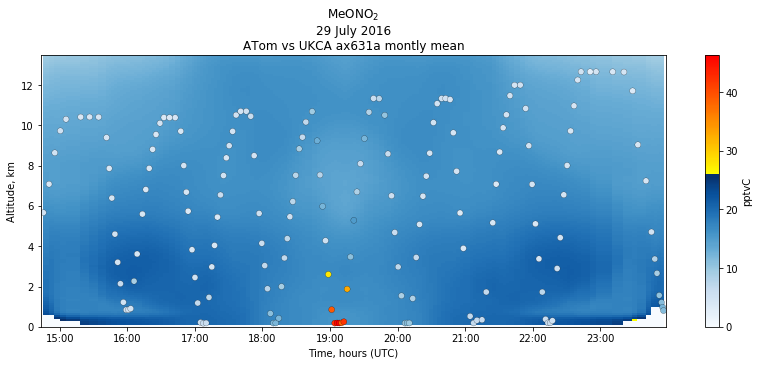

In [36]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(times, traj2d_cbr_meono2.coord('altitude').points, traj2d_cbr_meono2.data.squeeze(), 
                   norm=MidpointNormalize(midpoint=cs_meono2_min), vmax=cs_meono2_max, **cs_pc_kwargs)
p1 = ax.scatter(times, atom_dsmms.G_ALT, c=atom_pdwas_meono2.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_meono2_min), vmax=cs_meono2_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptvC')
# common
ax.set_title(f'{str_meono2}\n{atom_date_start.strftime("%d %B %Y")}\nATom vs UKCA {ukca_run_name} montly mean')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticklabels(times)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_cs_RONO2_C1.png', bbox_inches='tight')

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


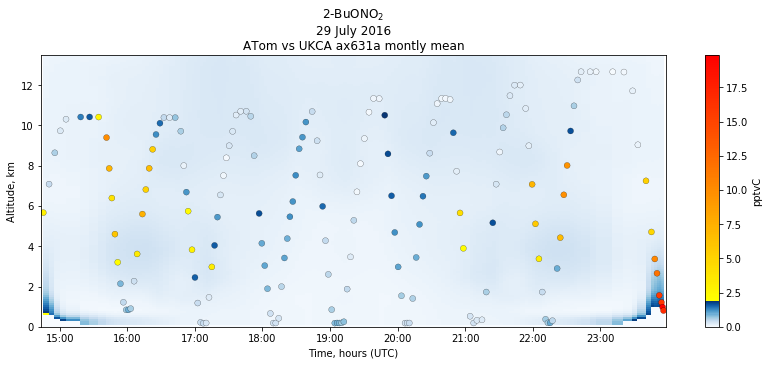

In [37]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(times, traj2d_cbr_sbuono2.coord('altitude').points, traj2d_cbr_sbuono2.data.squeeze(), 
                   norm=MidpointNormalize(midpoint=cs_sbuono2_min), vmax=cs_sbuono2_max, **cs_pc_kwargs)
p1 = ax.scatter(times, atom_dsmms.G_ALT, c=atom_pdwas_sbuono2.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_sbuono2_min), vmax=cs_sbuono2_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptvC')
# common
ax.set_title(f'{str_sbuono2}\n{atom_date_start.strftime("%d %B %Y")}\nATom vs UKCA {ukca_run_name} montly mean')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticklabels(times)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_cs_RONO2_C4s.png', bbox_inches='tight')

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


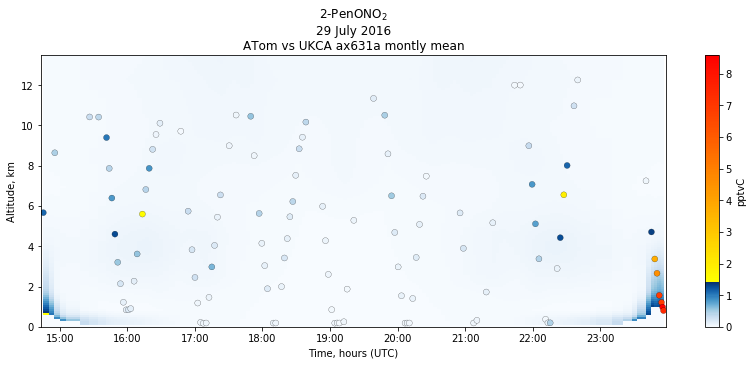

In [38]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(times, traj2d_cbr_n2peono2.coord('altitude').points, traj2d_cbr_n2peono2.data.squeeze(), 
                   norm=MidpointNormalize(midpoint=cs_n2peono2_min), vmax=cs_n2peono2_max, **cs_pc_kwargs)
p1 = ax.scatter(times, atom_dsmms.G_ALT, c=atom_pdwas_n2peono2.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_n2peono2_min), vmax=cs_n2peono2_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptvC')
# common
ax.set_title(f'{str_n2peono2}\n{atom_date_start.strftime("%d %B %Y")}\nATom vs UKCA {ukca_run_name} montly mean')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticklabels(times)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_cs_RONO2_C5nB.png', bbox_inches='tight')

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


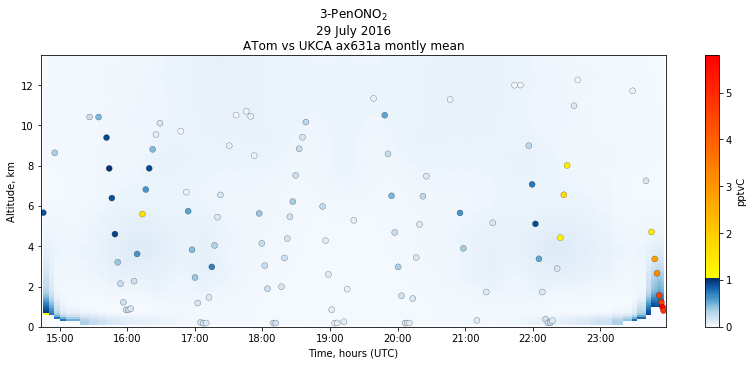

In [39]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(times, traj2d_cbr_n3peono2.coord('altitude').points, traj2d_cbr_n3peono2.data.squeeze(), 
                   norm=MidpointNormalize(midpoint=cs_n3peono2_min), vmax=cs_n3peono2_max, **cs_pc_kwargs)
p1 = ax.scatter(times, atom_dsmms.G_ALT, c=atom_pdwas_n3peono2.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_n3peono2_min), vmax=cs_n3peono2_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptvC')
# common
ax.set_title(f'{str_n3peono2}\n{atom_date_start.strftime("%d %B %Y")}\nATom vs UKCA {ukca_run_name} montly mean')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticklabels(times)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_cs_RONO2_C5nC.png', bbox_inches='tight')

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


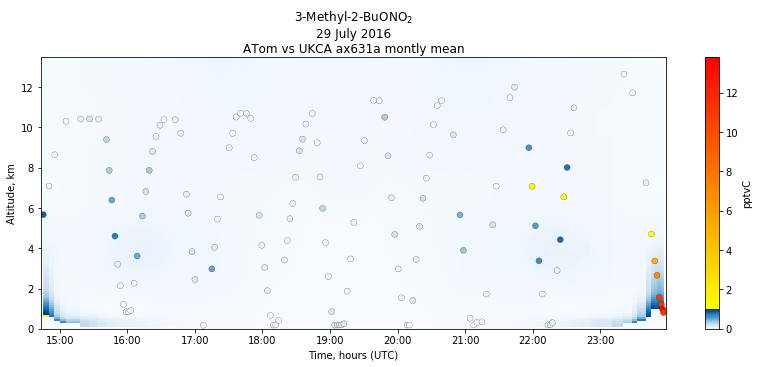

In [40]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(times, traj2d_cbr_ipeono2.coord('altitude').points, traj2d_cbr_ipeono2.data.squeeze(), 
                   norm=MidpointNormalize(midpoint=cs_ipeono2_min), vmax=cs_ipeono2_max, **cs_pc_kwargs)
p1 = ax.scatter(times, atom_dsmms.G_ALT, c=atom_pdwas_ipeono2.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_ipeono2_min), vmax=cs_ipeono2_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptvC')
# common
ax.set_title(f'{str_ipeono2}\n{atom_date_start.strftime("%d %B %Y")}\nATom vs UKCA {ukca_run_name} montly mean')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticklabels(times)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_cs_RONO2_C5i.png', bbox_inches='tight')

#### Flight concentrations at all altitudes and model surface concentration (hybrid height level 0) 

In [41]:
# Add a cyclic point to model data for plotting it on a map
cyclic_c2h6, cyclic_lons = cartopy.util.add_cyclic_point(cb_c2h6.data*2, coord=cb_c2h6.coord('longitude').points)
cyclic_c3h8 = cartopy.util.add_cyclic_point(cb_c3h8.data*3)
cyclic_nc4h10 = cartopy.util.add_cyclic_point(cb_nc4h10.data)
cyclic_ic4h10 = cartopy.util.add_cyclic_point(cb_ic4h10.data)
cyclic_nc5h12 = cartopy.util.add_cyclic_point(cb_nc5h12.data)
cyclic_ic5h12 = cartopy.util.add_cyclic_point(cb_ic5h12.data)
cyclic_meono2 = cartopy.util.add_cyclic_point(cb_meono2.data)
cyclic_sbuono2 = cartopy.util.add_cyclic_point(cb_sbuono2.data)
cyclic_n2peono2 = cartopy.util.add_cyclic_point(cb_n2peono2.data)
cyclic_n3peono2 = cartopy.util.add_cyclic_point(cb_n3peono2.data)
cyclic_ipeono2 = cartopy.util.add_cyclic_point(cb_ipeono2.data)

In [42]:
# Select longitudes and latitudes where ATom data is available
lons_c2h6_notnan = np.where(atom_pdwas_c2h6.Lumped_C2H6_C2H4_C2H2.isna()==False, sample_lons, atom_pdwas_c2h6.Lumped_C2H6_C2H4_C2H2)
lats_c2h6_notnan = np.where(atom_pdwas_c2h6.Lumped_C2H6_C2H4_C2H2.isna()==False, sample_lats, atom_pdwas_c2h6.Lumped_C2H6_C2H4_C2H2)
lons_c3h8_notnan = np.where(atom_pdwas_c3h8.Lumped_C3H8_C3H6.isna()==False, sample_lons, atom_pdwas_c3h8.Lumped_C3H8_C3H6)
lats_c3h8_notnan = np.where(atom_pdwas_c3h8.Lumped_C3H8_C3H6.isna()==False, sample_lats, atom_pdwas_c3h8.Lumped_C3H8_C3H6)
lons_nc4h10_notnan = np.where(atom_pdwas_nc4h10['n-Butane_WAS'].isna()==False, sample_lons, atom_pdwas_nc4h10['n-Butane_WAS'])
lats_nc4h10_notnan = np.where(atom_pdwas_nc4h10['n-Butane_WAS'].isna()==False, sample_lats, atom_pdwas_nc4h10['n-Butane_WAS'])
lons_ic4h10_notnan = np.where(atom_pdwas_ic4h10['i-Butane_WAS'].isna()==False, sample_lons, atom_pdwas_ic4h10['i-Butane_WAS'])
lats_ic4h10_notnan = np.where(atom_pdwas_ic4h10['i-Butane_WAS'].isna()==False, sample_lats, atom_pdwas_ic4h10['i-Butane_WAS'])
lons_nc5h12_notnan = np.where(atom_pdwas_nc5h12['n-Pentane_WAS'].isna()==False, sample_lons, atom_pdwas_nc5h12['n-Pentane_WAS'])
lats_nc5h12_notnan = np.where(atom_pdwas_nc5h12['n-Pentane_WAS'].isna()==False, sample_lats, atom_pdwas_nc5h12['n-Pentane_WAS'])
lons_ic5h12_notnan = np.where(atom_pdwas_ic5h12['i-Pentane_WAS'].isna()==False, sample_lons, atom_pdwas_ic5h12['i-Pentane_WAS'])
lats_ic5h12_notnan = np.where(atom_pdwas_ic5h12['i-Pentane_WAS'].isna()==False, sample_lats, atom_pdwas_ic5h12['i-Pentane_WAS'])
lons_meono2_notnan = np.where(atom_pdwas_meono2['MeONO2_WAS'].isna()==False, sample_lons, atom_pdwas_meono2['MeONO2_WAS'])
lats_meono2_notnan = np.where(atom_pdwas_meono2['MeONO2_WAS'].isna()==False, sample_lats, atom_pdwas_meono2['MeONO2_WAS'])
lons_sbuono2_notnan = np.where(atom_pdwas_sbuono2['2-BuONO2_WAS'].isna()==False, sample_lons, atom_pdwas_sbuono2['2-BuONO2_WAS'])
lats_sbuono2_notnan = np.where(atom_pdwas_sbuono2['2-BuONO2_WAS'].isna()==False, sample_lats, atom_pdwas_sbuono2['2-BuONO2_WAS'])
lons_n2peono2_notnan = np.where(atom_pdwas_n2peono2['2-PenONO2_WAS'].isna()==False, sample_lons, atom_pdwas_n2peono2['2-PenONO2_WAS'])
lats_n2peono2_notnan = np.where(atom_pdwas_n2peono2['2-PenONO2_WAS'].isna()==False, sample_lats, atom_pdwas_n2peono2['2-PenONO2_WAS'])
lons_n3peono2_notnan = np.where(atom_pdwas_n3peono2['3-PenONO2_WAS'].isna()==False, sample_lons, atom_pdwas_n3peono2['3-PenONO2_WAS'])
lats_n3peono2_notnan = np.where(atom_pdwas_n3peono2['3-PenONO2_WAS'].isna()==False, sample_lats, atom_pdwas_n3peono2['3-PenONO2_WAS'])
lons_ipeono2_notnan = np.where(atom_pdwas_ipeono2['3-Methyl-2-BuONO2_WAS'].isna()==False, sample_lons, atom_pdwas_ipeono2['3-Methyl-2-BuONO2_WAS'])
lats_ipeono2_notnan = np.where(atom_pdwas_ipeono2['3-Methyl-2-BuONO2_WAS'].isna()==False, sample_lats, atom_pdwas_ipeono2['3-Methyl-2-BuONO2_WAS'])

In [43]:
# Find max surface concentration in model data
mpglb_c2h6_max = int(cyclic_c2h6[0,0,...].max())
mpglb_c3h8_max = int(cyclic_c3h8[0,0,...].max())
mpglb_nc4h10_max = int(cyclic_nc4h10[0,0,...].max())
mpglb_ic4h10_max = int(cyclic_ic4h10[0,0,...].max())
mpglb_nc5h12_max = int(cyclic_nc5h12[0,0,...].max())
mpglb_ic5h12_max = int(cyclic_ic5h12[0,0,...].max())
mpglb_meono2_max = int(cyclic_meono2[0,0,...].max())
mpglb_sbuono2_max = int(cyclic_sbuono2[0,0,...].max())
mpglb_n2peono2_max = int(cyclic_n2peono2[0,0,...].max())
mpglb_n3peono2_max = int(cyclic_n3peono2[0,0,...].max())
mpglb_ipeono2_max = int(cyclic_ipeono2[0,0,...].max())
print(atom_ukca_datetime_match)
print(f'C2H6: {mpglb_c2h6_max}')
print(f'C3H8: {mpglb_c3h8_max}')
print(f'nC4H10: {mpglb_nc4h10_max}')
print(f'iC4H10: {mpglb_ic4h10_max}')
print(f'nC5H12: {mpglb_nc5h12_max}')
print(f'iC5H12: {mpglb_ic5h12_max}')
print(f'MeONO2: {mpglb_meono2_max}')
print(f'2-BuONO2: {mpglb_sbuono2_max}')
print(f'2-PenONO2: {mpglb_n2peono2_max}')
print(f'3-PenONO2: {mpglb_n3peono2_max}')
print(f'3-Methyl-2-BuONO2: {mpglb_ipeono2_max}')

160729_1607
C2H6: 219216
C3H8: 91924
nC4H10: 11800
iC4H10: 6375
nC5H12: 9603
iC5H12: 12846
MeONO2: 39
2-BuONO2: 99
2-PenONO2: 79
3-PenONO2: 57
3-Methyl-2-BuONO2: 56


In [44]:
# Choose a range that allows to display the variability in lower concentrations
mpglb_c2h6_range = np.arange(0,11000,1000)
mpglb_c3h8_range = np.arange(0,4500,500)
mpglb_nc4h10_range = np.arange(0,220,20)
mpglb_ic4h10_range = np.arange(0,220,20)
mpglb_nc5h12_range = np.arange(0,220,20)
mpglb_ic5h12_range = np.arange(0,220,20)
mpglb_meono2_range = np.arange(0,50,5)
mpglb_sbuono2_range = np.arange(0,11,1)
mpglb_n2peono2_range = np.arange(0,5.5,0.5)
mpglb_n3peono2_range = np.arange(0,5.5,0.5)
mpglb_ipeono2_range = np.arange(0,5.5,0.5)

In [45]:
# Global map plotting parameters
mp_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='Oranges', extend='max')
mp_sc_kwargs = dict(transform=ccrs.PlateCarree(), c='C0', edgecolors='k', linewidth=0.2)
# Add locations where ATom fligths stopped
if atom_ukca_datetime_match == '160729_1607':
    atom_stops = [dict(name='Palmdale', lon=-118.100556, lat=34.581111),
                  dict(name='Equator', lon=-120, lat=0)]

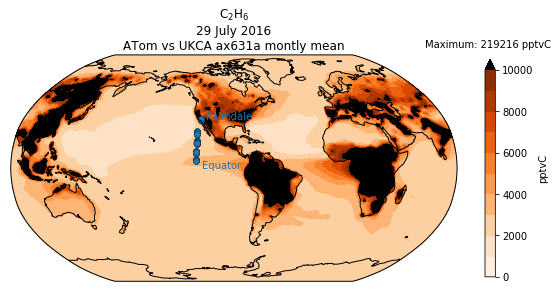

In [46]:
# Plot sampling locations and model surface concentration (hybrid height level 0)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=270)), facecolor='w')
p1 = ax.contourf(cyclic_lons, cbr_c2h6.coord('latitude').points, cyclic_c2h6[0,0,...], levels=mpglb_c2h6_range, **mp_cf_kwargs)
ax.scatter(lons_c2h6_notnan, lats_c2h6_notnan, **mp_sc_kwargs)
ax.coastlines()
ax.set_global()
ax.set_title(f'{str_c2h6}\n{atom_date_start.strftime("%d %B %Y")}\nATom vs UKCA {ukca_run_name} montly mean')
p1.cmap.set_over('k')
fig.colorbar(p1, shrink=0.4, label='pptvC', extend='max')
fig.text(0.7, 0.67, f'Maximum: {mpglb_c2h6_max} pptvC')
for i in atom_stops: ax.text(i['lon']+4, i['lat'], i['name'], transform=ccrs.PlateCarree(), color='C0')
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_mpglb_RH_C2.png', bbox_inches='tight')

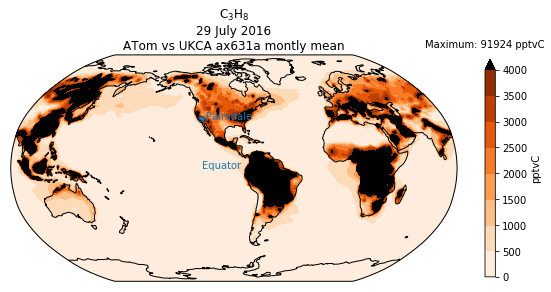

In [47]:
# Plot sampling locations and model surface concentration (hybrid height level 0)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=270)), facecolor='w')
p1 = ax.contourf(cyclic_lons, cbr_c3h8.coord('latitude').points, cyclic_c3h8[0,0,...], levels=mpglb_c3h8_range, **mp_cf_kwargs)
ax.scatter(lons_c3h8_notnan, lats_c3h8_notnan, **mp_sc_kwargs)
ax.coastlines()
ax.set_global()
ax.set_title(f'{str_c3h8}\n{atom_date_start.strftime("%d %B %Y")}\nATom vs UKCA {ukca_run_name} montly mean')
p1.cmap.set_over('k')
fig.colorbar(p1, shrink=0.4, label='pptvC', extend='max')
fig.text(0.7, 0.67, f'Maximum: {mpglb_c3h8_max} pptvC')
for i in atom_stops: ax.text(i['lon']+4, i['lat'], i['name'], transform=ccrs.PlateCarree(), color='C0')
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_mpglb_RH_C3.png', bbox_inches='tight')

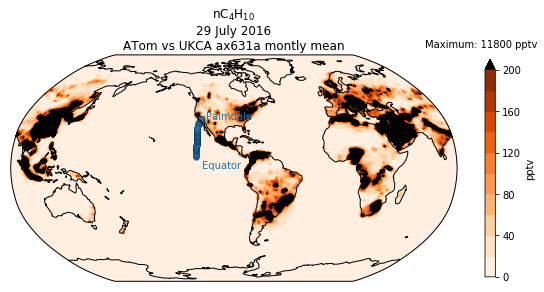

In [48]:
# Plot sampling locations and model surface concentration (hybrid height level 0)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=270)), facecolor='w')
p1 = ax.contourf(cyclic_lons, cbr_nc4h10.coord('latitude').points, cyclic_nc4h10[0,0,...], levels=mpglb_nc4h10_range, **mp_cf_kwargs)
ax.scatter(lons_nc4h10_notnan, lats_nc4h10_notnan, **mp_sc_kwargs)
ax.coastlines()
ax.set_global()
ax.set_title(f'{str_nc4h10}\n{atom_date_start.strftime("%d %B %Y")}\nATom vs UKCA {ukca_run_name} montly mean')
p1.cmap.set_over('k')
fig.colorbar(p1, shrink=0.4, label='pptv', extend='max')
fig.text(0.7, 0.67, f'Maximum: {mpglb_nc4h10_max} pptv')
for i in atom_stops: ax.text(i['lon']+4, i['lat'], i['name'], transform=ccrs.PlateCarree(), color='C0')
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_mpglb_RH_C4n.png', bbox_inches='tight')

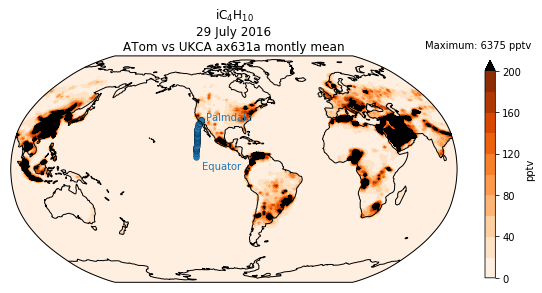

In [49]:
# Plot sampling locations and model surface concentration (hybrid height level 0)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=270)), facecolor='w')
p1 = ax.contourf(cyclic_lons, cbr_ic4h10.coord('latitude').points, cyclic_ic4h10[0,0,...], levels=mpglb_ic4h10_range, **mp_cf_kwargs)
ax.scatter(lons_ic4h10_notnan, lats_ic4h10_notnan, **mp_sc_kwargs)
ax.coastlines()
ax.set_global()
ax.set_title(f'{str_ic4h10}\n{atom_date_start.strftime("%d %B %Y")}\nATom vs UKCA {ukca_run_name} montly mean')
p1.cmap.set_over('k')
fig.colorbar(p1, shrink=0.4, label='pptv', extend='max')
fig.text(0.7, 0.67, f'Maximum: {mpglb_ic4h10_max} pptv')
for i in atom_stops: ax.text(i['lon']+4, i['lat'], i['name'], transform=ccrs.PlateCarree(), color='C0')
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_mpglb_RH_C4i.png', bbox_inches='tight')

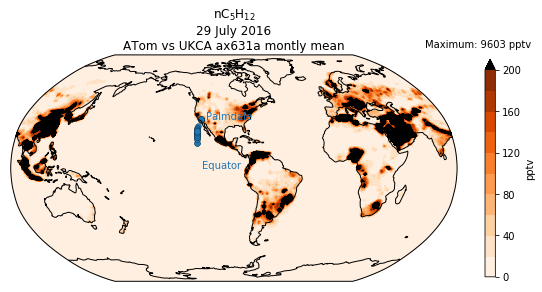

In [50]:
# Plot sampling locations and model surface concentration (hybrid height level 0)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=270)), facecolor='w')
p1 = ax.contourf(cyclic_lons, cbr_nc5h12.coord('latitude').points, cyclic_nc5h12[0,0,...], levels=mpglb_nc5h12_range, **mp_cf_kwargs)
ax.scatter(lons_nc5h12_notnan, lats_nc5h12_notnan, **mp_sc_kwargs)
ax.coastlines()
ax.set_global()
ax.set_title(f'{str_nc5h12}\n{atom_date_start.strftime("%d %B %Y")}\nATom vs UKCA {ukca_run_name} montly mean')
p1.cmap.set_over('k')
fig.colorbar(p1, shrink=0.4, label='pptv', extend='max')
fig.text(0.7, 0.67, f'Maximum: {mpglb_nc5h12_max} pptv')
for i in atom_stops: ax.text(i['lon']+4, i['lat'], i['name'], transform=ccrs.PlateCarree(), color='C0')
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_mpglb_RH_C5n.png', bbox_inches='tight')

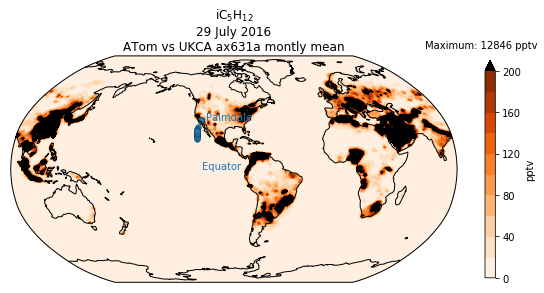

In [51]:
# Plot sampling locations and model surface concentration (hybrid height level 0)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=270)), facecolor='w')
p1 = ax.contourf(cyclic_lons, cbr_ic5h12.coord('latitude').points, cyclic_ic5h12[0,0,...], levels=mpglb_ic5h12_range, **mp_cf_kwargs)
ax.scatter(lons_ic5h12_notnan, lats_ic5h12_notnan, **mp_sc_kwargs)
ax.coastlines()
ax.set_global()
ax.set_title(f'{str_ic5h12}\n{atom_date_start.strftime("%d %B %Y")}\nATom vs UKCA {ukca_run_name} montly mean')
p1.cmap.set_over('k')
fig.colorbar(p1, shrink=0.4, label='pptv', extend='max')
fig.text(0.7, 0.67, f'Maximum: {mpglb_ic5h12_max} pptv')
for i in atom_stops: ax.text(i['lon']+4, i['lat'], i['name'], transform=ccrs.PlateCarree(), color='C0')
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_mpglb_RH_C5i.png', bbox_inches='tight')

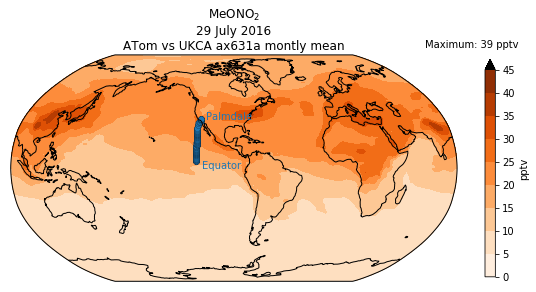

In [52]:
# Plot sampling locations and model surface concentration (hybrid height level 0)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=270)), facecolor='w')
p1 = ax.contourf(cyclic_lons, cbr_meono2.coord('latitude').points, cyclic_meono2[0,0,...], levels=mpglb_meono2_range, **mp_cf_kwargs)
ax.scatter(lons_meono2_notnan, lats_meono2_notnan, **mp_sc_kwargs)
ax.coastlines()
ax.set_global()
ax.set_title(f'{str_meono2}\n{atom_date_start.strftime("%d %B %Y")}\nATom vs UKCA {ukca_run_name} montly mean')
p1.cmap.set_over('k')
fig.colorbar(p1, shrink=0.4, label='pptv', extend='max')
fig.text(0.7, 0.67, f'Maximum: {mpglb_meono2_max} pptv')
for i in atom_stops: ax.text(i['lon']+4, i['lat'], i['name'], transform=ccrs.PlateCarree(), color='C0')
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_mpglb_RONO2_C1.png', bbox_inches='tight')

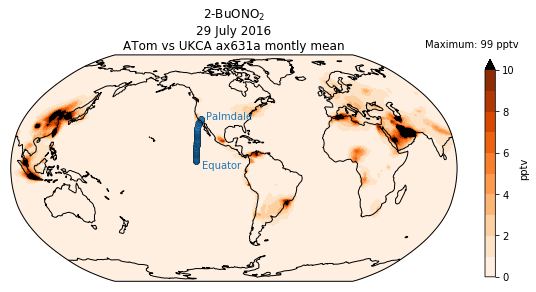

In [53]:
# Plot sampling locations and model surface concentration (hybrid height level 0)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=270)), facecolor='w')
p1 = ax.contourf(cyclic_lons, cbr_sbuono2.coord('latitude').points, cyclic_sbuono2[0,0,...], levels=mpglb_sbuono2_range, **mp_cf_kwargs)
ax.scatter(lons_sbuono2_notnan, lats_sbuono2_notnan, **mp_sc_kwargs)
ax.coastlines()
ax.set_global()
ax.set_title(f'{str_sbuono2}\n{atom_date_start.strftime("%d %B %Y")}\nATom vs UKCA {ukca_run_name} montly mean')
p1.cmap.set_over('k')
fig.colorbar(p1, shrink=0.4, label='pptv', extend='max')
fig.text(0.7, 0.67, f'Maximum: {mpglb_sbuono2_max} pptv')
for i in atom_stops: ax.text(i['lon']+4, i['lat'], i['name'], transform=ccrs.PlateCarree(), color='C0')
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_mpglb_RONO2_C4s.png', bbox_inches='tight')

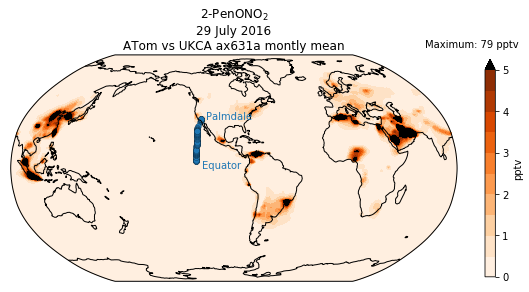

In [54]:
# Plot sampling locations and model surface concentration (hybrid height level 0)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=270)), facecolor='w')
p1 = ax.contourf(cyclic_lons, cbr_n2peono2.coord('latitude').points, cyclic_n2peono2[0,0,...], levels=mpglb_n2peono2_range, **mp_cf_kwargs)
ax.scatter(lons_n2peono2_notnan, lats_n2peono2_notnan, **mp_sc_kwargs)
ax.coastlines()
ax.set_global()
ax.set_title(f'{str_n2peono2}\n{atom_date_start.strftime("%d %B %Y")}\nATom vs UKCA {ukca_run_name} montly mean')
p1.cmap.set_over('k')
fig.colorbar(p1, shrink=0.4, label='pptv', extend='max')
fig.text(0.7, 0.67, f'Maximum: {mpglb_n2peono2_max} pptv')
for i in atom_stops: ax.text(i['lon']+4, i['lat'], i['name'], transform=ccrs.PlateCarree(), color='C0')
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_mpglb_RONO2_C5nB.png', bbox_inches='tight')

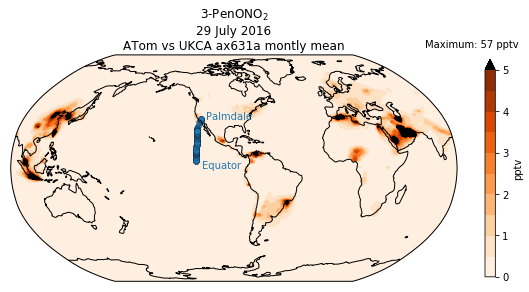

In [55]:
# Plot sampling locations and model surface concentration (hybrid height level 0)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=270)), facecolor='w')
p1 = ax.contourf(cyclic_lons, cbr_n3peono2.coord('latitude').points, cyclic_n3peono2[0,0,...], levels=mpglb_n3peono2_range, **mp_cf_kwargs)
ax.scatter(lons_n3peono2_notnan, lats_n3peono2_notnan, **mp_sc_kwargs)
ax.coastlines()
ax.set_global()
ax.set_title(f'{str_n3peono2}\n{atom_date_start.strftime("%d %B %Y")}\nATom vs UKCA {ukca_run_name} montly mean')
p1.cmap.set_over('k')
fig.colorbar(p1, shrink=0.4, label='pptv', extend='max')
fig.text(0.7, 0.67, f'Maximum: {mpglb_n3peono2_max} pptv')
for i in atom_stops: ax.text(i['lon']+4, i['lat'], i['name'], transform=ccrs.PlateCarree(), color='C0')
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_mpglb_RONO2_C5nC.png', bbox_inches='tight')

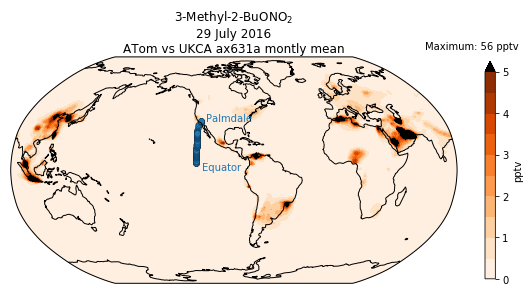

In [56]:
# Plot sampling locations and model surface concentration (hybrid height level 0)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=270)), facecolor='w')
p1 = ax.contourf(cyclic_lons, cbr_ipeono2.coord('latitude').points, cyclic_ipeono2[0,0,...], levels=mpglb_ipeono2_range, **mp_cf_kwargs)
ax.scatter(lons_ipeono2_notnan, lats_ipeono2_notnan, **mp_sc_kwargs)
ax.coastlines()
ax.set_global()
ax.set_title(f'{str_ipeono2}\n{atom_date_start.strftime("%d %B %Y")}\nATom vs UKCA {ukca_run_name} montly mean')
p1.cmap.set_over('k')
fig.colorbar(p1, shrink=0.4, label='pptv', extend='max')
fig.text(0.7, 0.67, f'Maximum: {mpglb_ipeono2_max} pptv')
for i in atom_stops: ax.text(i['lon']+4, i['lat'], i['name'], transform=ccrs.PlateCarree(), color='C0')
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_mpglb_RONO2_C5i.png', bbox_inches='tight')

#### Plot all flight track data as a scatter plot

In [57]:
# Find max concentration between observational and model trajectory data
sct_max_c2h6 = max(np.nanmax(atom_pdwas_c2h6.values), np.nanmax(traj3d_cbr_c2h6.data*2))
sct_max_c3h8 = max(np.nanmax(atom_pdwas_c3h8.values), np.nanmax(traj3d_cbr_c3h8.data*3))
sct_max_nc4h10 = max(np.nanmax(atom_pdwas_nc4h10.values), np.nanmax(traj3d_cbr_nc4h10.data))
sct_max_ic4h10 = max(np.nanmax(atom_pdwas_ic4h10.values), np.nanmax(traj3d_cbr_ic4h10.data))
sct_max_nc5h12 = max(np.nanmax(atom_pdwas_nc5h12.values), np.nanmax(traj3d_cbr_nc5h12.data))
sct_max_ic5h12 = max(np.nanmax(atom_pdwas_ic5h12.values), np.nanmax(traj3d_cbr_ic5h12.data))
sct_max_meono2 = max(np.nanmax(atom_pdwas_meono2.values), np.nanmax(traj3d_cbr_meono2.data))
sct_max_sbuono2 = max(np.nanmax(atom_pdwas_sbuono2.values), np.nanmax(traj3d_cbr_sbuono2.data))
sct_max_n2peono2 = max(np.nanmax(atom_pdwas_n2peono2.values), np.nanmax(traj3d_cbr_n2peono2.data))
sct_max_n3peono2 = max(np.nanmax(atom_pdwas_n3peono2.values), np.nanmax(traj3d_cbr_n3peono2.data))
sct_max_ipeono2 = max(np.nanmax(atom_pdwas_ipeono2.values), np.nanmax(traj3d_cbr_ipeono2.data))

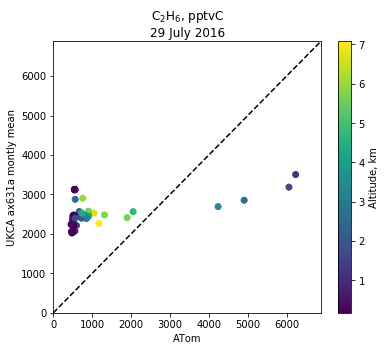

In [58]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_pdwas_c2h6.squeeze(), traj3d_cbr_c2h6.data.squeeze()*2, c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_c2h6+1], [0, sct_max_c2h6+1], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_c2h6}, pptvC\n{atom_date_start.strftime("%d %B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} montly mean')
ax.set_xlim(0, sct_max_c2h6+1)
ax.set_ylim(0, sct_max_c2h6+1)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_1to1_RH_C2.png', bbox_inches='tight')

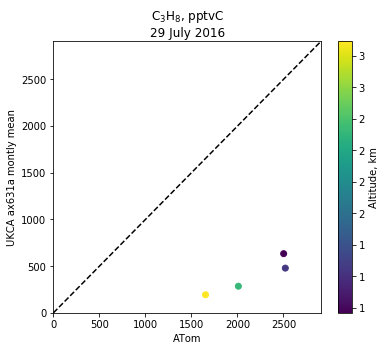

In [59]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_pdwas_c3h8.squeeze(), traj3d_cbr_c3h8.data.squeeze()*3, c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_c3h8+1], [0, sct_max_c3h8+1], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_c3h8}, pptvC\n{atom_date_start.strftime("%d %B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} montly mean')
ax.set_xlim(0, sct_max_c3h8+1)
ax.set_ylim(0, sct_max_c3h8+1)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_1to1_RH_C3.png', bbox_inches='tight')

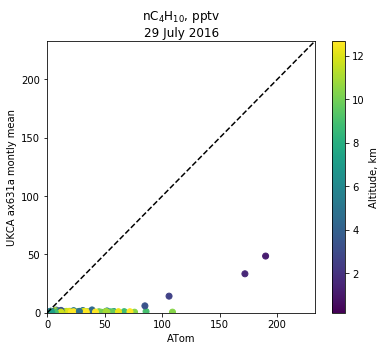

In [60]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_pdwas_nc4h10.squeeze(), traj3d_cbr_nc4h10.data.squeeze(), c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_nc4h10+1], [0, sct_max_nc4h10+1], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_nc4h10}, pptv\n{atom_date_start.strftime("%d %B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} montly mean')
ax.set_xlim(0, sct_max_nc4h10+1)
ax.set_ylim(0, sct_max_nc4h10+1)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_1to1_RH_C4n.png', bbox_inches='tight')

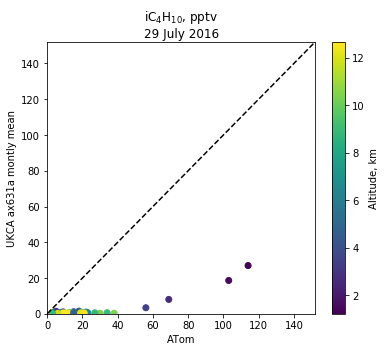

In [61]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_pdwas_ic4h10.squeeze(), traj3d_cbr_ic4h10.data.squeeze(), c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_ic4h10+1], [0, sct_max_ic4h10+1], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_ic4h10}, pptv\n{atom_date_start.strftime("%d %B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} montly mean')
ax.set_xlim(0, sct_max_ic4h10+1)
ax.set_ylim(0, sct_max_ic4h10+1)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_1to1_RH_C4i.png', bbox_inches='tight')

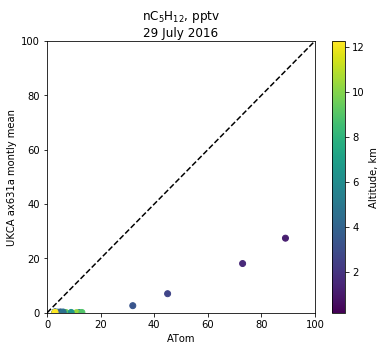

In [62]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_pdwas_nc5h12.squeeze(), traj3d_cbr_nc5h12.data.squeeze(), c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_nc5h12+1], [0, sct_max_nc5h12+1], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_nc5h12}, pptv\n{atom_date_start.strftime("%d %B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} montly mean')
ax.set_xlim(0, sct_max_nc5h12+1)
ax.set_ylim(0, sct_max_nc5h12+1)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_1to1_RH_C5n.png', bbox_inches='tight')

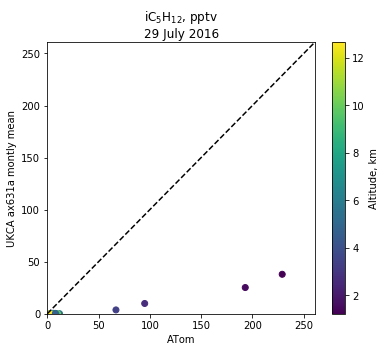

In [63]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_pdwas_ic5h12.squeeze(), traj3d_cbr_ic5h12.data.squeeze(), c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_ic5h12+1], [0, sct_max_ic5h12+1], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_ic5h12}, pptv\n{atom_date_start.strftime("%d %B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} montly mean')
ax.set_xlim(0, sct_max_ic5h12+1)
ax.set_ylim(0, sct_max_ic5h12+1)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_1to1_RH_C5i.png', bbox_inches='tight')

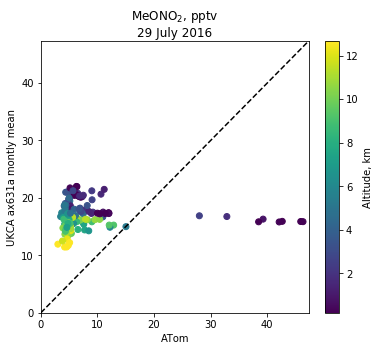

In [64]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_pdwas_meono2.squeeze(), traj3d_cbr_meono2.data.squeeze(), c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_meono2+1], [0, sct_max_meono2+1], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_meono2}, pptv\n{atom_date_start.strftime("%d %B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} montly mean')
ax.set_xlim(0, sct_max_meono2+1)
ax.set_ylim(0, sct_max_meono2+1)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_1to1_RONO2_C1.png', bbox_inches='tight')

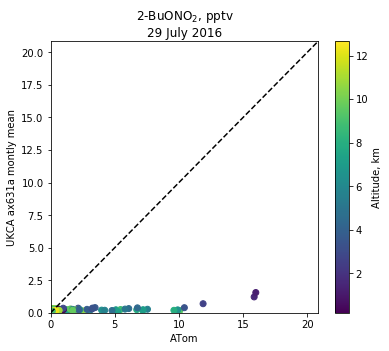

In [65]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_pdwas_sbuono2.squeeze(), traj3d_cbr_sbuono2.data.squeeze(), c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_sbuono2+1], [0, sct_max_sbuono2+1], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_sbuono2}, pptv\n{atom_date_start.strftime("%d %B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} montly mean')
ax.set_xlim(0, sct_max_sbuono2+1)
ax.set_ylim(0, sct_max_sbuono2+1)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_1to1_RONO2_C4s.png', bbox_inches='tight')

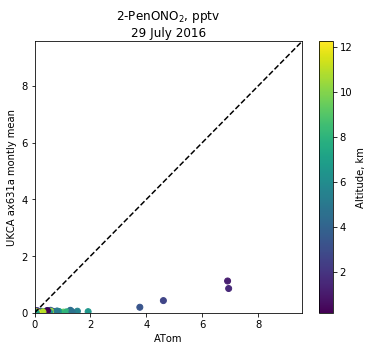

In [66]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_pdwas_n2peono2.squeeze(), traj3d_cbr_n2peono2.data.squeeze(), c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_n2peono2+1], [0, sct_max_n2peono2+1], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_n2peono2}, pptv\n{atom_date_start.strftime("%d %B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} montly mean')
ax.set_xlim(0, sct_max_n2peono2+1)
ax.set_ylim(0, sct_max_n2peono2+1)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_1to1_RONO2_C5nB.png', bbox_inches='tight')

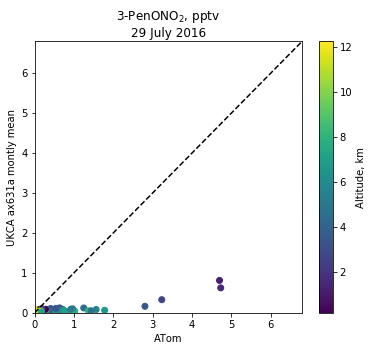

In [67]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_pdwas_n3peono2.squeeze(), traj3d_cbr_n3peono2.data.squeeze(), c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_n3peono2+1], [0, sct_max_n3peono2+1], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_n3peono2}, pptv\n{atom_date_start.strftime("%d %B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} montly mean')
ax.set_xlim(0, sct_max_n3peono2+1)
ax.set_ylim(0, sct_max_n3peono2+1)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_1to1_RONO2_C5nC.png', bbox_inches='tight')

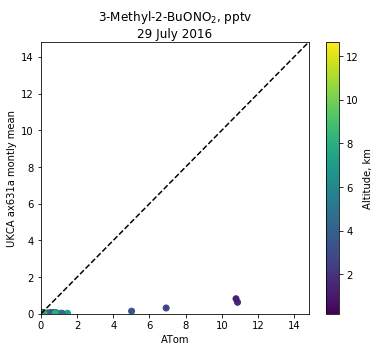

In [68]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_pdwas_ipeono2.squeeze(), traj3d_cbr_ipeono2.data.squeeze(), c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_ipeono2+1], [0, sct_max_ipeono2+1], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_ipeono2}, pptv\n{atom_date_start.strftime("%d %B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} montly mean')
ax.set_xlim(0, sct_max_ipeono2+1)
ax.set_ylim(0, sct_max_ipeono2+1)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_1to1_RONO2_C5i.png', bbox_inches='tight')

#### Vertical profile along flight track

In [69]:
# Choose bins
alt_bins = np.arange(0, 14000, 500)
alt_mod_bin_inds = np.arange(0, len(alt_bins), 1)
alt_obs_bin_inds = np.digitize(atom_dsmms.G_ALT.data, alt_bins)
# Bin observational data
obs_meono2_bin_mean = atom_pdwas_meono2.groupby(alt_obs_bin_inds).mean().reindex(index=alt_mod_bin_inds, fill_value=np.nan)
obs_meono2_bin_min = atom_pdwas_meono2.groupby(alt_obs_bin_inds).min().reindex(index=alt_mod_bin_inds, fill_value=np.nan)
obs_meono2_bin_max = atom_pdwas_meono2.groupby(alt_obs_bin_inds).max().reindex(index=alt_mod_bin_inds, fill_value=np.nan)
# Convert iris cube with model data to pandas dataframe
traj_cbr2pd_meono2 = traj3d_cbr_meono2.copy()
traj_cbr2pd_meono2.remove_coord('t')
traj_cbr2pd_meono2.remove_coord('longitude')
traj_cbr2pd_meono2.remove_coord('latitude')
# for cube in cubes:
#     for i in ('t', 'longitude', 'latitude'):
#         cube.remove_coord(i)
traj_pd_meono2 = iris.pandas.as_data_frame(traj_cbr2pd_meono2).T
# Bin model data
mod_meono2_bin_mean = traj_pd_meono2.groupby(alt_obs_bin_inds).mean().reindex(index=alt_mod_bin_inds, fill_value=np.nan)
mod_meono2_bin_min = traj_pd_meono2.groupby(alt_obs_bin_inds).min().reindex(index=alt_mod_bin_inds, fill_value=np.nan)
mod_meono2_bin_max = traj_pd_meono2.groupby(alt_obs_bin_inds).max().reindex(index=alt_mod_bin_inds, fill_value=np.nan)

In [78]:
# Vertical profile plotting parameters
vp_barh_kwargs = dict(height=200, align='center', alpha=0.7)

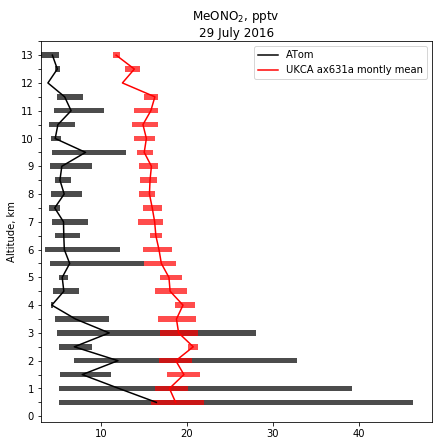

In [79]:
# Plot vertical profile along flight track
fig, ax = plt.subplots(figsize=(7,7), facecolor='w')
ax.plot(obs_meono2_bin_mean, alt_bins, color='k')
ax.barh(alt_bins, obs_meono2_bin_max.MeONO2_WAS-obs_meono2_bin_min.MeONO2_WAS, left=obs_meono2_bin_min.MeONO2_WAS, color='k', **vp_barh_kwargs)
ax.plot(mod_meono2_bin_mean, alt_bins, color='r')
ax.barh(alt_bins, (mod_meono2_bin_max[0]-mod_meono2_bin_min[0]), left=mod_meono2_bin_min[0], color='r', **vp_barh_kwargs)
# common
ax.set_title(f'{str_meono2}, pptv\n{atom_date_start.strftime("%d %B %Y")}')
ax.set_ylabel('Altitude, km')
ax.set_ylim(-200,13500)
ax.set_yticks(alt_bins)
ax.set_yticklabels(map(int,(alt_bins/1000)))
ax.legend(['ATom', 'UKCA ax631a montly mean'])
for ytcklbl in ax.yaxis.get_ticklabels()[1::2]:
    ytcklbl.set_visible(False)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_vp_RONO2_C1.png', bbox_inches='tight')

In [ ]:
# # Useful reference code
# from cf_units import Unit
# # Correct hybrid_height units from 'unknown' to 'm'
# cb_meono2.coord('Hybrid height').units = Unit('m')
# # Add surface_altitude coordinate to the cube
# new_coord = iris.coords.AuxCoord(cb_srf_alt.data, standard_name='surface_altitude', units='m')
# cb_meono2.add_aux_coord(new_coord, data_dims=[2, 3])
# # Derive altitude coordinate from surface_altitude
# factory = iris.aux_factory.HybridHeightFactory(delta=cb_meono2.coord('Hybrid height'), 
#                                                orography=cb_meono2.coord('surface_altitude'))
# cb_meono2.add_aux_factory(factory)
# # Relevel model data from hybrid_height to target levels (called here height)
# tgt_levels = np.arange(0, 14000, 100)
# height_coord = cb_meono2.coord('altitude').copy() # avoid duplication of coordinate names
# height_coord.rename('height')
# src_levels = height_coord

# cbr_meono2 = stratify.relevel(cb_meono2, src_levels, tgt_levels, axis='Hybrid height')

In [ ]:
# UKCA diagnostic (nudged) runs variable names
# field2101 O3 MASS MIXING RATIO AFTER TIMESTEP
# field2181 OH MASS MIXING RATIO AFTER TIMESTEP
# field2182 HO2 MASS MIXING RATIO AFTER TIMESTEP

# field2102 NO MASS MIXING RATIO AFTER TIMESTEP
# field2110 CO MASS MIXING RATIO AFTER TSTEP
# field2109 CH4 MASS MIXING RATIO AFTER TSTEP
# field2114 C2H6 MASS MIXING RATIO AFTER TSTEP
# field2118 C3H8 MASS MIXING RATIO AFTER TSTEP
# field2273 n-C4H10 MASS MIXING RATIO AFTER TS
# field2274 i-C4H10 MASS MIXING RATIO AFTER TS
# field2275 n-C5H12 MASS MIXING RATIO AFTER TS
# field2276 i-C5H12 MASS MIXING RATIO AFTER TS

# field2125 MeONO2 MASS MIXING RATIO AFTER TSTEP
# field2287 n-BuONO2 MASS MIXING RATIO AFTER TS
# field2288 s-BuONO2 MASS MIXING RATIO AFTER TS
# field2289 n-2PeONO2 MASS MIXING RATIO AFTER TS
# field2290 n-3PeONO2 MASS MIXING RATIO AFTER TS
# field2291 i-PeONO2 MASS MIXING RATIO AFTER TS

# field2164 IDT1 MASS MIXING RATIO AFTER TS global 5 day
# field2165 IDT2 MASS MIXING RATIO AFTER TS global 30 day
# field2165_13 IDT19 MASS MIXING RATIO AFTER TS N America 5 day
# field2165_14 IDT20 MASS MIXING RATIO AFTER TS N America 30 day
# field2165_17 IDT23 MASS MIXING RATIO AFTER TS Europe 5 day
# field2165_18 IDT24 MASS MIXING RATIO AFTER TS Europe 30 day
# field2165_19 IDT25 MASS MIXING RATIO AFTER TS N Africa 5 day
# field2165_20 IDT26 MASS MIXING RATIO AFTER TS N Africa 30 day